In [6]:
from gym_car_intersect.envs.hack_env_discrete import CarRacingHackaton
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import tensorflow as tf
from tensorflow.keras.layers import Dense, Concatenate, Flatten, Softmax
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

В ноутбуке реализован Soft Actor Acritic для дискретного пространства действий.

В самом низу тетрадки небольшое описание проделанного.

Ниже несколько классов-оберток для удобства обучения.

In [3]:
class SAC__ValueNet(tf.keras.Model):
    '''
    Implementaion of V function
    '''
    
    def __init__(self, session, state_size, action_size, hidden_size=128, name='_v1'):
        super(SAC__ValueNet, self).__init__()
        # (None, state_size) -> (None, hidden_size)
        self.d1 = Dense(units=hidden_size, activation='relu', dtype=tf.float32)
        # (hidden_size, state_size) -> (None, hidden_size)
        self.d2 = Dense(units=hidden_size, activation='relu', dtype=tf.float32)
        # (hidden_size, state_size) -> (None, 1)
        self.value = Dense(units=1, activation=None, dtype=tf.float32)

        # use stop gradient to prevent the gradient spreading to target, that is `Q(s, a) - log(pi(a|s))`
        self.optimizer = Adam(0.003)
            
    @tf.function    
    def __call__(self, state):
        return self.value(self.d2(self.d1(state)))

In [4]:
class SAC__QNet(tf.keras.Model):
    '''
    Implementation of Q function.
    '''
    
    def __init__(self, state_size, action_size, hidden_size=128, name='_v1'):
        super(SAC__QNet, self).__init__()
        self.d_state = Dense(units=hidden_size, activation='relu', dtype=tf.float32)
        self.d_action = Dense(units=hidden_size, activation='relu', dtype=tf.float32)

        # self.concat = tf.concat([x_state, x_action], axis=1)
        self.d1 = Dense(units=hidden_size, activation='relu', dtype=tf.float32)
        self.d2 = Dense(units=hidden_size, activation='relu', dtype=tf.float32)
        # final shape [None, 1]
        self.qvalue = Dense(units=1, dtype=tf.float32)

        self.optimizer = Adam(0.003)
            
    @tf.function
    def __call__(self, state, action):
        x = Concatenate(axis=1)([self.d_state(state), self.d_action(action)])
        x = self.d1(x)
        x = self.d2(x)
        return self.qvalue(x)

In [14]:
q = SAC__QNet(4, 3, 12)
q(np.array([[1, 1, 1, 1]]), np.array([[2, 2, 2]]))

<tf.Tensor: id=1474, shape=(1, 1), dtype=float32, numpy=array([[0.72314024]], dtype=float32)>

In [5]:
class SAC__Policy(tf.keras.Model):
    '''
    Implementation of Policy function.
    '''
    def __init__(self, state_size, action_size, hidden_size=128, name='_v1'):
        super(SAC__Policy, self).__init__()
        self.d1 = Dense(units=hidden_size, activation='relu', dtype=tf.float32)
        self.d2 = Dense(units=hidden_size, activation='relu', dtype=tf.float32)
        # final shape [None, 1]
        self.d3 = Dense(units=action_size, dtype=tf.float32)
        self.soft_max = Softmax(axis=1)
        self.gumbel_softmax = Softmax(axis=1)
        
        self.optimizer = Adam(learning_rate=0.003)
        
    def _gumbel_softmax(self, prob, temperature=0.5):
        u = np.random.uniform(low=0.0, high=1.0, size=(prob.shape)).astype(np.float32)
        u = -np.log(-np.log(u))
        
        return self.gumbel_softmax( (prob + u) / temperature )
        
        
    def __call__(self, state, temperature=0.5, use_gumbel=False):
        probs = self.soft_max(self.d3(self.d2(self.d1(state))))
        if not use_gumbel:
            return probs
        else:
            return self._gumbel_softmax(probs, temperature)

In [284]:
class SAC__Agent:
    '''
    Class of agent, whitch controll update steps of all sub-net and can be used in expluatation.
    '''
    def __init__(self, 
                 state_size, 
                 action_size, 
                 hidden_size=256, 
                 name='agent_1', 
                 info=''):
        # save meta info
        self.name = name
        self.info = info
        
        # save env hyper params
        self.action_size = action_size
        self.state_size = state_size
        
        # here init agent nets
        self._Q1 = SAC__QNet(state_size, action_size, hidden_size, '_q1')
        self._Q2 = SAC__QNet(state_size, action_size, hidden_size, '_q2')
        self._V = SAC__ValueNet(state_size, action_size, hidden_size, '_v')
        self._V_Smooth = SAC__ValueNet(state_size, action_size, hidden_size, '_v_smooth')
        self._Policy = SAC__Policy(state_size, action_size, hidden_size, '_p1')

        
    def get_batch_actions(self, state, need_argmax=False, use_gumbel=True, temperature=0.5):
        # state: [batch_size, state_size]
        actions = self._Policy(state, use_gumbel=use_gumbel, temperature=temperature)
        if need_argmax:
            return np.argmax(actions, axis=1)
        return actions
    
    def get_single_action(self, state, need_argmax=False, use_gumbel=True, temperature=0.5):
        # state: [state_size, ]
        # return [action_szie, ]
        action = self._Policy(np.array([state]), temperature=temperature, use_gumbel=use_gumbel)[0]
        if need_argmax:
            return np.argmax(action)
        return action

        
    def update_step(
            self, 
            replay_batch, 
            temperature=0.5, 
            gamma=0.7,
            v_exp_smooth_factor=0.8,
            need_update_VSmooth=False,
    ):
        # shape of treplay_batch : tuple of (
        #     [batch_size, state_size], - state
        #     [batch_size, actoin_size],- action
        #     [batch_size, 1],          - revard
        #     [batch_size, state_size], - new state
        #     [batch_size, 1]           - is it done? (1 for done, 0 for not yet)
        # )
        
        with tf.GradientTape() as tape:
            state, action, reward, new_state, done_flag = replay_batch
            batch_size = len(state)

            # cur_policy_actions is [batch_size, action_szie]
            next_action_prob = self._Policy(new_state, use_gumbel=True)
            next_actions_log_probs = tf.reshape(
                tf.math.log(tf.reduce_max(next_action_prob, axis=1)),
                (batch_size, 1),
            )
            next_action = np.reshape(
                tf.one_hot(
                    np.argmax(next_action_prob, axis=1),
                    self.action_size,
                ),
                (batch_size, self.action_size),
            )


            # shape: [batch_size, 1], get min of Q function in accordance with ariginal article
            q_func_next = np.min(
                np.array([
                    self._Q1(new_state, next_action),
                    self._Q2(new_state, next_action),
                ]),
                axis=0
            )
            q_func_target = tf.cast(
                reward + gamma * (1 - done_flag) * (q_func_next - temperature * next_actions_log_probs),
                tf.float32
            )
            loss_q1 = tf.reduce_mean( (self._Q1(state, action) - tf.stop_gradient(q_func_target))**2 )
            loss_q2 = tf.reduce_mean( (self._Q2(state, action) - tf.stop_gradient(q_func_target))**2 )
            loss_policy = tf.reduce_mean( 
                    (
                        tf.stop_gradient(q_func_next) - next_actions_log_probs * temperature
                    )**2 
                )
        
            
            grads = tape.gradient(
                [loss_q1, loss_q2, loss_policy], 
                [
                    *self._Q1.trainable_variables, 
                    *self._Q2.trainable_variables, 
                    *self._Policy.trainable_variables,
                ],
            )
            grad_q1 = grads[:len(self._Q1.trainable_variables)]
#             print(f'q1 need {len(self._Q1.trainable_variables)}')
#             print(f'grad_q1 : shape = {len(grad_q1)}')
            
            self._Q1.optimizer.apply_gradients(zip(grad_q1, self._Q1.trainable_variables))
            
            grad_q2 = grads[
                len(self._Q1.trainable_variables)
                : 
                len(self._Q1.trainable_variables) + len(self._Q2.trainable_variables)
            ]
#             print(f'q2 need {len(self._Q2.trainable_variables)}')
#             print(f'grad_q2 : shape = {len(grad_q2)}')
            
            self._Q2.optimizer.apply_gradients(zip(grad_q2, self._Q2.trainable_variables))

            
            grad_policy = grads[len(self._Q1.trainable_variables) + len(self._Q2.trainable_variables):]
#             print(f'policy need {len(self._Policyad_policy)}')
            
            
            self._Policy.optimizer.apply_gradients(zip(grad_policy, self._Policy.trainable_variables))
    

In [286]:
test_Agent = SAC__Agent(state_size=3, action_size=2)

# batch size = 4
test_Agent.update_step((
    np.array([[1, 1, 1], [2, 2, 2], [1, 2, 3], [2, 3, 4]]), # state
    np.array([[0, 1], [0, 1], [1, 0], [1, 0]]), # action
    np.array([[1], [2], [3], [-1]]), # reward
    np.array([[1, 1, 2], [2, 2, 3], [1, 3, 3], [2, 2, 4]]), # new state
    np.array([[0], [0], [0], [1]]) # done
))


# print(test_Agent.get_single_action([1, 2, 3], need_argmax=True, temperature=100))
# print(test_Agent.get_batch_actions(
#     [[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3]],
#     need_argmax=True, 
#     temperature=0.01
# ))

In [278]:
test_Agent.get_single_action(np.array([1, 2, 3]), use_gumbel=True)

*
[[ 0.88764423 -0.49663594]]


<tf.Tensor: id=42517, shape=(2,), dtype=float32, numpy=array([0.788872  , 0.21112798], dtype=float32)>

In [287]:
test_Agent.get_batch_actions(np.array([[1, 2, 3], [1, 2, 3]]), use_gumbel=True)

<tf.Tensor: id=45963, shape=(2, 2), dtype=float32, numpy=
array([[0.01879195, 0.9812081 ],
       [0.08417294, 0.9158271 ]], dtype=float32)>

будем учить агента, исользуя как состояние его координаты и точку назначания

In [332]:
class Holder:
    '''
    Class to hold agent, environment and replay buffer. 
    Also it is a place to controll hyperparameters of learning process.
    '''
    
    def __init__(self, batch_size=256, hidden_size=256, buffer_size=100 * 1000):
        self.batch_size = batch_size
        
        # for reward history 
        self.update_steps_count = 0
        self.game_count = 0
        self.history = []
        
        # init replay buffer
        self.cur_write_index = 0
        self.buffer_size = buffer_size
        self.buffer = [
            np.zeros((buffer_size, 5), dtype=np.float32),
            np.zeros((buffer_size, 5), dtype=np.float32),
            np.zeros((buffer_size, 1), dtype=np.float32),
            np.zeros((buffer_size, 5), dtype=np.float32),
            np.zeros((buffer_size, 1), dtype=np.float32),
        ]
        
        # init environment and agent
        self.env = CarRacingHackaton(num_bots=0, start_file=None)
        self.agent = SAC__Agent(state_size=5, action_size=5, hidden_size=hidden_size)
        self.goal = None
        
    def reset_env(self, inc_counter=True):
        self.env.reset()
        if inc_counter:
            self.game_count += 1
        goal = np.array(self.env.car_goal_poly)
        self.goal = np.array([np.mean(goal[:, 0]), np.mean(goal[:, 1])])
        
        
    def insert_N_sample_to_replay_memory(self, N, temperature=0.5):
        for _ in range(N):
            
            # resen env, if we hanen't goal
            if self.goal is None:
                self.reset_env()
            
            state = np.hstack([self.env.state[1], self.goal])
            action = self.agent.get_single_action(
                state,
                need_argmax=False,
                temperature=temperature,
            )
            new_state, reward, done, info = self.env.step(np.argmax(action))
            
            # state
            self.buffer[0][self.cur_write_index] = state
            # action
            self.buffer[1][self.cur_write_index] = action
            # reward
            self.buffer[2][self.cur_write_index] = np.array([reward])
            # new state
            self.buffer[3][self.cur_write_index] = np.hstack([np.array(new_state[1]), self.goal])
            # done flag
            self.buffer[4][self.cur_write_index] = 1.0 if done else 0.0
            self.cur_write_index += 1
            if self.cur_write_index >= self.buffer_size:
                self.cur_write_index =  0
            
            # reset env if done
            if done:
                self.reset_env()
                
                
    def iterate_over_buffer(self, steps):
        cur_steps = 0
        is_break = False
        while True:
            indexes = np.arange(len(self.buffer[0]))
            np.random.shuffle(indexes)
            
            for ind in range(0, len(indexes), self.batch_size):
                yield (
                    self.buffer[i][indexes[ind : ind + self.batch_size]]
                    for i in range(5)
                )
                cur_steps += 1
                if cur_steps >= steps:
                    is_break = True
                    break
            if is_break:
                break
    
    def update_agent(
            self, 
            update_step_num=500,
            temperature=0.5,
            gamma=0.7,
            v_exp_smooth_factor=0.8,
            need_update_VSmooth=False
    ):
        for batch in self.iterate_over_buffer(update_step_num):
            self.update_steps_count += 1
            self.agent.update_step(
                batch, 
                temperature=temperature, 
                gamma=gamma,
                v_exp_smooth_factor=v_exp_smooth_factor,
                need_update_VSmooth=need_update_VSmooth,
            )
            
    def iterate_over_test_game(self, max_steps=1000):
        self.reset_env(inc_counter=True)
        was_game_finit = False
        for _ in range(max_steps):
            state = np.hstack([self.env.state[1], self.goal])
            action = self.agent.get_single_action(
                state,
                need_argmax=False,
                temperature=1,
            )
            new_state, reward, done, info = self.env.step(np.argmax(action))
            
            yield self.env.state[0], action, reward, done
            
            if done:
                was_game_finit = True
                break
        return None, None, was_game_finit
            
    def get_test_game_total_reward(
            self, 
            max_steps=1000, 
            temperature=10,
            add_to_memory=True,
    ):
        total_reward = 0
        was_game_finit = False
        
        for _, _, reward, done in self.iterate_over_test_game(max_steps=1000):
            if done:
                break
            total_reward += reward

            
        if add_to_memory:
            self.history.append([self.game_count, total_reward])
        
        return total_reward
    
    
    def get_test_game_mean_reward(
        self,
        n_games=10,
        max_steps=1000, 
        temperature=10,
        add_to_memory=True
    ):
        sm = 0
        for _ in range(n_games):
            sm += self.get_test_game_total_reward(max_steps, temperature, add_to_memory=False)
        sm /= n_games
        
        if add_to_memory:            
            self.history.append([self.game_count, sm])
            
        return sm
    
    def get_history(self):
        return np.array(self.history)

In [333]:
def visualize(agent_holder, fig, ax):
    for state, action, reward, done in agent_holder.iterate_over_test_game(max_steps=200):
        if done:
            break
        print(f'reward : {reward}')
        print(f'argmaxed action : {np.argmax(action)}')
        print(f'action : {action}')
        clear_output(wait = True)
        ax.imshow(state)
        display(fig)


        plt.pause(0.5)

Инициализируем финальный граф

In [334]:
holder = Holder()

In [335]:
%time

# fill replay buffer with random exploratoin actions


holder.insert_N_sample_to_replay_memory(1000, temperature=0.00001)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11.4 µs


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

visualize(holder, fig, ax)

In [336]:
holder.get_test_game_mean_reward()

3.3

потретируем модель

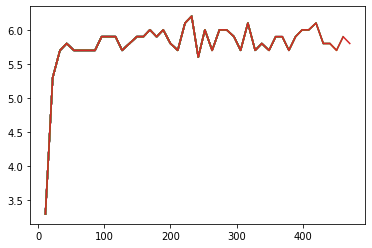

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

for i in range(10 * 1000):
    gamma = min(0.9, 0.1 + i / 5000)
    temperature = min(1.5, 0.2 + i / 1000)
    
    holder.insert_N_sample_to_replay_memory(1000, temperature=temperature - 0.1)
    holder.update_agent(update_step_num=100, temperature=temperature, gamma=gamma)

    holder.get_test_game_mean_reward()
    
    clear_output(wait = True)
    ax.plot(holder.get_history()[:, 0], holder.get_history()[:, 1])
    display(fig)
    
    
    plt.pause(0.5)

чуть более детальный график

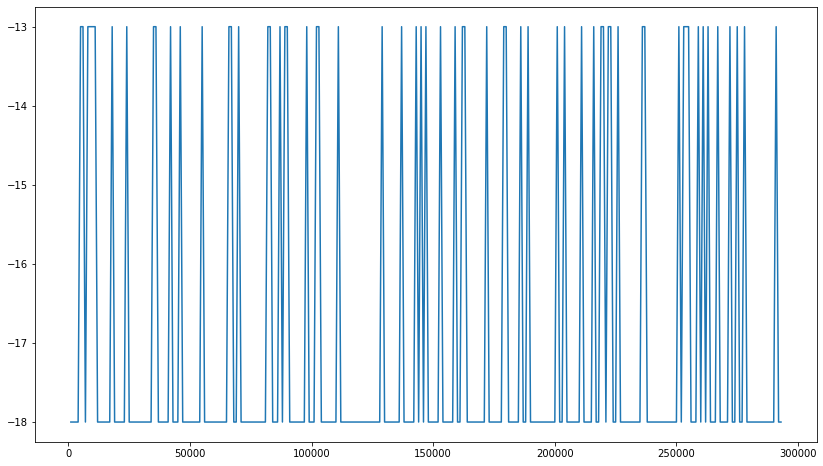

In [20]:
plt.figure(figsize=(14, 8)) 
plt.plot(holder.get_history()[:, 0], holder.get_history()[:, 1])
plt.show()

**Про проделанную работу**

Прочитал статью написал код. Во время написания понял, что сферическое нормальное распределение (как в оригинальной стате) не подойдет для дискретного пространства действий и, поискав, применил Gumbel-Softmax для применения reparametrization trick в дискретном пространстве.

Далее некоторое время настраивал среду и обучал агента. Как видно на графике ревордов промежуточных игр, агент пока не обучился делать хоть что-то разумное. В то же время в оригинальное статье на графиках видно обучение по несколько миллионов игр, а здесь агент сыграл чуть больше 1000.

Нужно бы обучать агента дольше (у меня после неписания кода осталось немного времени) и попробовать сделать больше нейронов в слоях (в оригинальной статье 256 на слой, у меня 16 в силу небольшой вычислительной мощности).